# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random

In [2]:
import warnings

warnings.filterwarnings("ignore")

## 1. 데이터 로딩

In [3]:
data_dir = "/opt/ml/input/data/"
csv_file_path = os.path.join(data_dir, "train_data.csv")
df = pd.read_csv(csv_file_path)

## 2. Feature Engineering

In [4]:
def feature_engineering(df):

    # 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=["userID", "Timestamp"], inplace=True)

    # 유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df["user_correct_answer"] = df.groupby("userID")["answerCode"].transform(
        lambda x: x.cumsum().shift(1)
    )
    df["user_total_answer"] = df.groupby("userID")["answerCode"].cumcount()
    df["user_acc"] = df["user_correct_answer"] / df["user_total_answer"]

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(["testId"])["answerCode"].agg(["mean", "sum"])
    correct_t.columns = ["test_mean", "test_sum"]
    correct_k = df.groupby(["KnowledgeTag"])["answerCode"].agg(["mean", "sum"])
    correct_k.columns = ["tag_mean", "tag_sum"]

    df = pd.merge(df, correct_t, on=["testId"], how="left")
    df = pd.merge(df, correct_k, on=["KnowledgeTag"], how="left")

    return df

In [5]:
df = feature_engineering(df)

## 3. Train/Test 데이터 셋 분리

In [6]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)


def custom_train_test_split(df, ratio=0.7, split=True):

    users = list(zip(df["userID"].value_counts().index, df["userID"].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio * len(df)
    sum_of_train_data = 0
    user_ids = []

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    train = df[df["userID"].isin(user_ids)]
    test = df[df["userID"].isin(user_ids) == False]

    # test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test["userID"] != test["userID"].shift(-1)]
    return train, test

In [7]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = [
    "KnowledgeTag",
    "user_correct_answer",
    "user_total_answer",
    "user_acc",
    "test_mean",
    "test_sum",
    "tag_mean",
    "tag_sum",
]

# X, y 값 분리
y_train = train["answerCode"]
train = train.drop(["answerCode"], axis=1)

y_test = test["answerCode"]
test = test.drop(["answerCode"], axis=1)

In [8]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [9]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [25]:
params = {
    "objective": "binary",
    "bagging_fraction": 0.61,
    "bagging_seed": 11,
    "learning_rate": 0.05,
    "num_iterations": 1000,
    "max_depth": -1,
    "boosting": "gbdt",
    "early_stopping": 35,
    "feature_fraction": 0.56,
    "num_leaves": 150,
    "min_child_weight": 0.03454472573214212,
    "reg_alpha": 0.3899927210061127,
    "reg_lambda": 0.6485237330340494,
    "random_state": 47,
    "metric": "auc",
    "verbosity": -1,
}
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100,
)
preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

Training until validation scores don't improve for 35 rounds
[100]	training's auc: 0.742324	valid_1's auc: 0.687548
[200]	training's auc: 0.749115	valid_1's auc: 0.688454
Early stopping, best iteration is:
[213]	training's auc: 0.749605	valid_1's auc: 0.688694


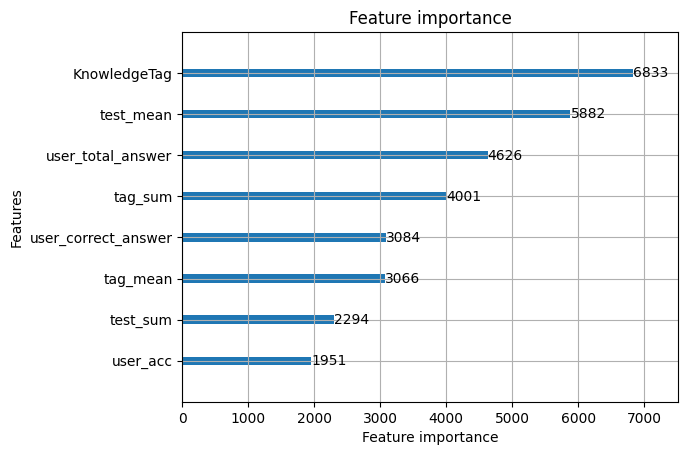

In [26]:
_ = lgb.plot_importance(model)

## 5. Inference

In [27]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, "test_data.csv")
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df["userID"] != test_df["userID"].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(["answerCode"], axis=1)

In [28]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [29]:
# SAVE OUTPUT
output_dir = "output/"
write_path = os.path.join(output_dir, "lgbm_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : output/lgbm_submission.csv


### Optuna example

In [16]:
# !pip install optuna

  Using cached optuna-3.0.3-py3-none-any.whl (348 kB)
  Using cached cmaes-0.9.0-py3-none-any.whl (23 kB)
  Using cached scipy-1.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.2 MB)
  Using cached cliff-4.1.0-py3-none-any.whl (81 kB)
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached SQLAlchemy-1.4.44-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached PyYAML-6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (682 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached alembic-1.8.1-py3-none-any.whl (209 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached greenlet-2.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (539 kB)
  Using cached autopage-0.5.1-py3-none-any.whl (29 kB)
  Using cached prettytable-3.5.0-

In [19]:
# import optuna
# from optuna import Trial
# from optuna.samplers import TPESampler

In [22]:
# def objective(trial: Trial):
#     params = {
#         'objective': 'binary',
#         'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 0.8, step=0.01),
#         'bagging_seed': trial.suggest_categorical("seed", [11, 42]), ##
#         'learning_rate': trial.suggest_categorical("lr", [0.001, 0.005, 0.01, 0.05, 0.1]),
#         'num_iterations': trial.suggest_int("n_iter", 100, 1500, 100),
#         'max_depth': trial.suggest_categorical('max_depth', [-1, 1, 2]), # need to consider
#         'boosting': 'gbdt',
#         'early_stopping': trial.suggest_int('patience', 5, 40, 5),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.8, step=0.01),
#         'num_leaves': trial.suggest_int('num_leaves', 100, 500, 50),
#         'min_child_weight': 0.03454472573214212,
#         'reg_alpha': 0.3899927210061127,
#         'reg_lambda': 0.6485237330340494,
#         'random_state': 47,
#         "metric": 'auc',
#         "verbosity": -1,
#     }
#     model = lgb.train(
#         params,
#         lgb_train,
#         valid_sets=[lgb_train, lgb_test],
#         verbose_eval=100,
#         num_boost_round=500,
#         early_stopping_rounds=100
#     )

#     preds = model.predict(test[FEATS])
#     acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
#     auc = roc_auc_score(y_test, preds)

#     return auc

# sampler = TPESampler(seed=42)
# study = optuna.create_study(
#     study_name="lgbm_parameter_opt",
#     direction="maximize",
#     sampler=sampler,
# )
# study.optimize(objective, n_trials=10)
# print("Best Score:", study.best_value)
# print("Best trial:", study.best_trial.params)

[I 2022-11-27 15:41:50,013] A new study created in memory with name: lgbm_parameter_opt


Training until validation scores don't improve for 35 rounds
[100]	training's auc: 0.730837	valid_1's auc: 0.686892
[200]	training's auc: 0.732632	valid_1's auc: 0.688471
[300]	training's auc: 0.733352	valid_1's auc: 0.689047


[I 2022-11-27 15:42:23,286] Trial 0 finished with value: 0.6893346253229974 and parameters: {'bagging_fraction': 0.61, 'seed': 11, 'lr': 0.1, 'n_iter': 1000, 'max_depth': 2, 'patience': 35, 'feature_fraction': 0.56, 'num_leaves': 150}. Best is trial 0 with value: 0.6893346253229974.


Early stopping, best iteration is:
[342]	training's auc: 0.733544	valid_1's auc: 0.689335
Training until validation scores don't improve for 25 rounds
[100]	training's auc: 0.71322	valid_1's auc: 0.670182
[200]	training's auc: 0.719881	valid_1's auc: 0.676716
[300]	training's auc: 0.723281	valid_1's auc: 0.679914
[400]	training's auc: 0.725231	valid_1's auc: 0.681326
[500]	training's auc: 0.726439	valid_1's auc: 0.682213


[I 2022-11-27 15:43:02,114] Trial 1 finished with value: 0.6828274696879348 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 600, 'max_depth': 1, 'patience': 25, 'feature_fraction': 0.6799999999999999, 'num_leaves': 100}. Best is trial 0 with value: 0.6893346253229974.


[600]	training's auc: 0.727222	valid_1's auc: 0.682825
Did not meet early stopping. Best iteration is:
[599]	training's auc: 0.727224	valid_1's auc: 0.682827
Training until validation scores don't improve for 5 rounds


[I 2022-11-27 15:43:03,556] Trial 2 finished with value: 0.6683452593917711 and parameters: {'bagging_fraction': 0.6799999999999999, 'seed': 11, 'lr': 0.005, 'n_iter': 1100, 'max_depth': 2, 'patience': 5, 'feature_fraction': 0.78, 'num_leaves': 200}. Best is trial 0 with value: 0.6893346253229974.


Early stopping, best iteration is:
[19]	training's auc: 0.710755	valid_1's auc: 0.668345
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.705852	valid_1's auc: 0.662731
[200]	training's auc: 0.715562	valid_1's auc: 0.672321
[300]	training's auc: 0.719935	valid_1's auc: 0.677394
[400]	training's auc: 0.722361	valid_1's auc: 0.67957


[I 2022-11-27 15:43:32,762] Trial 3 finished with value: 0.6801947922878155 and parameters: {'bagging_fraction': 0.7, 'seed': 42, 'lr': 0.01, 'n_iter': 1400, 'max_depth': 1, 'patience': 10, 'feature_fraction': 0.51, 'num_leaves': 200}. Best is trial 0 with value: 0.6893346253229974.


Early stopping, best iteration is:
[444]	training's auc: 0.723117	valid_1's auc: 0.680195
Training until validation scores don't improve for 5 rounds


[I 2022-11-27 15:43:36,568] Trial 4 finished with value: 0.6877971576227391 and parameters: {'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.1, 'n_iter': 200, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.75, 'num_leaves': 400}. Best is trial 0 with value: 0.6893346253229974.


Early stopping, best iteration is:
[23]	training's auc: 0.745908	valid_1's auc: 0.687797
Training until validation scores don't improve for 30 rounds


[I 2022-11-27 15:43:42,533] Trial 5 finished with value: 0.6782115881534487 and parameters: {'bagging_fraction': 0.72, 'seed': 11, 'lr': 0.01, 'n_iter': 100, 'max_depth': 2, 'patience': 30, 'feature_fraction': 0.77, 'num_leaves': 300}. Best is trial 0 with value: 0.6893346253229974.


[100]	training's auc: 0.72177	valid_1's auc: 0.678212
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.72177	valid_1's auc: 0.678212
Training until validation scores don't improve for 15 rounds


[I 2022-11-27 15:43:47,912] Trial 6 finished with value: 0.6732995428344265 and parameters: {'bagging_fraction': 0.53, 'seed': 42, 'lr': 0.005, 'n_iter': 100, 'max_depth': 2, 'patience': 15, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 0 with value: 0.6893346253229974.


Early stopping, best iteration is:
[76]	training's auc: 0.716516	valid_1's auc: 0.6733
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.728696	valid_1's auc: 0.682946
[200]	training's auc: 0.729956	valid_1's auc: 0.685412


[I 2022-11-27 15:44:02,010] Trial 7 finished with value: 0.6854964221824686 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.1, 'n_iter': 1300, 'max_depth': 1, 'patience': 10, 'feature_fraction': 0.77, 'num_leaves': 300}. Best is trial 0 with value: 0.6893346253229974.


Early stopping, best iteration is:
[207]	training's auc: 0.730018	valid_1's auc: 0.685496
Training until validation scores don't improve for 5 rounds


[I 2022-11-27 15:44:06,758] Trial 8 finished with value: 0.6880485986881335 and parameters: {'bagging_fraction': 0.75, 'seed': 11, 'lr': 0.1, 'n_iter': 100, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.6, 'num_leaves': 500}. Best is trial 0 with value: 0.6893346253229974.


Early stopping, best iteration is:
[25]	training's auc: 0.74853	valid_1's auc: 0.688049
Training until validation scores don't improve for 25 rounds


[I 2022-11-27 15:44:09,440] Trial 9 finished with value: 0.6683243887895051 and parameters: {'bagging_fraction': 0.6, 'seed': 42, 'lr': 0.005, 'n_iter': 500, 'max_depth': 2, 'patience': 25, 'feature_fraction': 0.51, 'num_leaves': 200}. Best is trial 0 with value: 0.6893346253229974.


Early stopping, best iteration is:
[20]	training's auc: 0.711723	valid_1's auc: 0.668324
Best Score: 0.6893346253229974
Best trial: {'bagging_fraction': 0.61, 'seed': 11, 'lr': 0.1, 'n_iter': 1000, 'max_depth': 2, 'patience': 35, 'feature_fraction': 0.56, 'num_leaves': 150}
